# Regresión Logística: ejemplo 1

In [1]:
# Solo si ce corre en Google Colab
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression

spark = SparkSession.builder.appName('EjemploRegLog1').getOrCreate()

In [ ]:
# Datos de entrenamiento
data = spark.read.format("libsvm").load("/content/datos_reg_log.libsvm.txt")

# Separación de los datos en entrenamiento y prueba (70% / 30%)
data_train, data_test = data.randomSplit([0.7, 0.3])

# Mostrar algunos de los datos
data_train.show(5, truncate=False)

## 1. Entrenamiento

In [4]:
# Modelo de regresión logística
reglog = LogisticRegression(predictionCol='prediccion')

# Ajustar a los datos de entrenamiento (entrenar el modelo)
modelo = reglog.fit(data_train)   

In [5]:
# Tipo de dato de "modelo"
modelo

LogisticRegressionModel: uid=LogisticRegression_d8e785c696e8, numClasses=2, numFeatures=692

In [6]:
print("Etiquetas (clases) del modelo:", modelo.summary.labels)

# True Positives (por etiqueta)
print("TP para entrenamiento:", modelo.summary.truePositiveRateByLabel)     

# False Positives (por etiqueta)
print("FP para entrenamiento:", modelo.summary.falsePositiveRateByLabel)

Etiquetas (clases) del modelo: [0.0, 1.0]
TP para entrenamiento: [1.0, 1.0]
FP para entrenamiento: [0.0, 0.0]


In [7]:
accuracy = modelo.summary.accuracy
AUC = modelo.summary.areaUnderROC

print("Exactitud en el conjunto de entrenamiento:", accuracy)
print("Área bajo la curva ROC en el conjunto de entrenamiento:", AUC)

Exactitud en el conjunto de entrenamiento: 1.0
Área bajo la curva ROC en el conjunto de entrenamiento: 1.0


In [8]:
# Resultados de entrenamiento: esquema de la salida
modelo.summary.predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediccion: double (nullable = false)



In [9]:
# Ejemplos de resultados de entrenamiento
modelo.summary.predictions.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediccion|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(692,[95,96,97,12...|[21.3623427583336...|[0.99999999947222...|       0.0|
|  0.0|(692,[98,99,100,1...|[28.0782617446973...|[0.99999999999936...|       0.0|
|  0.0|(692,[100,101,102...|[18.9419616133997...|[0.99999999406240...|       0.0|
|  0.0|(692,[122,123,148...|[20.8931479853493...|[0.99999999915623...|       0.0|
|  0.0|(692,[123,124,125...|[27.8195077426374...|[0.99999999999917...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



## 2. Evaluación

In [10]:
# Evaluación del clasificador (con el conjunto de prueba "test")
resultado = modelo.evaluate(data_test)

# Ver los resultados con el conjunto de prueba
resultado.predictions.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediccion|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(692,[121,122,123...|[20.3850134910585...|[0.99999999859750...|       0.0|
|  0.0|(692,[122,123,124...|[14.4252915621358...|[0.99999945653042...|       0.0|
|  0.0|(692,[124,125,126...|[29.9356058201162...|[0.99999999999990...|       0.0|
|  0.0|(692,[126,127,128...|[26.9300480952993...|[0.99999999999798...|       0.0|
|  0.0|(692,[126,127,128...|[30.1090376878383...|[0.99999999999991...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [11]:
type(resultado)

pyspark.ml.classification.BinaryLogisticRegressionSummary

In [12]:
resultado.predictions.select('label','prediccion').show(5)

+-----+----------+
|label|prediccion|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



In [13]:
# True Positives (por etiqueta)
print("TP para prueba:", resultado.truePositiveRateByLabel)     

# False Positives (por etiqueta)
print("FP para prueba:", resultado.falsePositiveRateByLabel)

TP para prueba: [1.0, 1.0]
FP para prueba: [0.0, 0.0]


In [14]:
accuracy = resultado.accuracy
auc = resultado.areaUnderROC

print("Exactitud en el conjunto de prueba:", accuracy)
print("Área bajo la curva ROC en el conjunto de prueba:", auc)

Exactitud en el conjunto de prueba: 1.0
Área bajo la curva ROC en el conjunto de prueba: 1.0


In [15]:
# Datos de la curva roc
resultado.roc.show(5)

roc = resultado.roc.collect()
roc[:5]

+---+------+
|FPR|   TPR|
+---+------+
|0.0|   0.0|
|0.0|0.0625|
|0.0| 0.125|
|0.0|0.1875|
|0.0|  0.25|
+---+------+
only showing top 5 rows



[Row(FPR=0.0, TPR=0.0),
 Row(FPR=0.0, TPR=0.0625),
 Row(FPR=0.0, TPR=0.125),
 Row(FPR=0.0, TPR=0.1875),
 Row(FPR=0.0, TPR=0.25)]

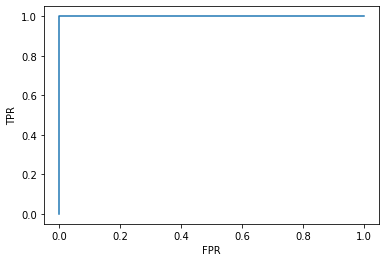

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Curva roc
n = len(roc)
FPR = np.zeros(n); TPR = np.zeros(n)
for idx, elem in enumerate(roc):
  FPR[idx] = elem.FPR
  TPR[idx] = elem.TPR

plt.plot(FPR, TPR)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()

### Evaluación

In [17]:
from pyspark.ml.evaluation import (BinaryClassificationEvaluator,
                                   MulticlassClassificationEvaluator)

In [18]:
# Creación del evaluador (indicando qué columna es la predicción y cuál la etiqueta real)
evaluador = BinaryClassificationEvaluator(rawPredictionCol='prediccion', labelCol='label', 
                                          metricName='areaUnderROC')

# Evaluación del área bajo la curva ROC de la salida anterior
AUC = evaluador.evaluate(resultado.predictions)

print("AUC:", AUC)

AUC: 1.0


In [19]:
# Evaluador de la exactitud (accuracy)
evaluador2 = MulticlassClassificationEvaluator(predictionCol='prediccion', labelCol='label',
                                               metricName='accuracy')

exactitud = evaluador2.evaluate(resultado.predictions)

print("Exactitud:", exactitud)

Exactitud: 1.0
